In [2]:
!git clone https://github.com/yossigandelsman/rosetta_neurons.git

Cloning into 'rosetta_neurons'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (141/141), done.
remote: Total 152 (delta 42), reused 95 (delta 7), pack-reused 0
Receiving objects: 100% (152/152), 35.27 MiB | 30.71 MiB/s, done.
Resolving deltas: 100% (42/42), done.


In [3]:
%cd rosetta_neurons

/kaggle/working/rosetta_neurons


In [4]:
import torch
device = torch.device('cuda:0')
dino = torch.hub.load('facebookresearch/dino:main', 'dino_resnet50').to(device)

Downloading: "https://github.com/facebookresearch/dino/zipball/main" to /root/.cache/torch/hub/main.zip
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://dl.fbaipublicfiles.com/dino/dino_resnet50_pretrain/dino_resnet50_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dino_resnet50_pretrain.pth
100%|██████████| 90.0M/90.0M [00:00<00:00, 174MB/s] 


In [5]:
#@title Requirements
!pip install -r requirements.txt
!pip install transformers
!pip install openai-clip
!pip install einops
!pip install pytorch_pretrained_biggan
!pip install Ninja
!pip install timm==0.4.12
!pip install dill

  Cloning https://github.com/openai/CLIP.git (to revision b46f5ac7587d2e1862f8b7b1573179d80dcdd620) to /tmp/pip-install-vphlb083/clip_03d0703d84724095b1aba39c0d5d5a1e
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-install-vphlb083/clip_03d0703d84724095b1aba39c0d5d5a1e
  Running command git rev-parse -q --verify 'sha^b46f5ac7587d2e1862f8b7b1573179d80dcdd620'
  Running command git fetch -q https://github.com/openai/CLIP.git b46f5ac7587d2e1862f8b7b1573179d80dcdd620
  Running command git checkout -q b46f5ac7587d2e1862f8b7b1573179d80dcdd620
  Resolved https://github.com/openai/CLIP.git to commit b46f5ac7587d2e1862f8b7b1573179d80dcdd620
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/arogozhnikov/einops.git (to revision d6f7910dc80c8413b7bb400f6f6ad24e3c5f5b0f) to /tmp/pip-install-vphlb083/einops_391766c867e34730932bef7271e11581
  Running command git clone --filter=blob:none --quiet https://github.com/arogozhnikov/eino

In [6]:
from transformers import CLIPProcessor, CLIPModel
import torch
import torchvision
from torchvision.models import resnet50
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import clip
from PIL import Image
import requests
import torch.hub
import time
import pickle
import math

from match_utils import matching, stats, proggan, nethook, dataset, loading, plotting, layers, models

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:
!pip install gdown==4.6.3
!gdown "https://drive.google.com/uc?export=download&id=1nB5RQPrWRfcLI7yHhKKkf4gjxrJW7HCj" -O 'stylegan2-cat-config-f.pt'

Downloading...
From: https://drive.google.com/uc?export=download&id=1nB5RQPrWRfcLI7yHhKKkf4gjxrJW7HCj
To: /kaggle/working/rosetta_neurons/stylegan2-cat-config-f.pt
100%|█████████████████████████████████████████| 121M/121M [00:00<00:00, 192MB/s]


In [8]:
from pytorch_pretrained_biggan import (BigGAN, one_hot_from_names, truncated_noise_sample,
                                       save_as_images, display_in_terminal)


gan, gan_layers = models.load_gan('stylegan2-lsun_cat', path='/kaggle/working/rosetta_neurons/', device=device)    
dino, dino_layers = models.load_discr('dino', path='models/', device=device)

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [9]:
ganlayers, dinolayers = layers.get_layers(gan,gan_layers, dino, dino_layers,"stylegan2-lsun_cat", "dino", device)

/kaggle/working/rosetta_neurons/stylegan2/op/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 2.0.0. Falling back to torch.nn.functional.conv2d().
  warnings.warn(


In [10]:
import os
table, gan_stats, dino_stats = loading.load_stats("/kaggle/input/style-gan2-lsun-cat/rosetta_neurons/matches/stylegan2-lsun_cat/dino", 
                                                  device)

save_path = "/kaggle/working/rosetta_neurons/inversion_images_stylegan2/"
if not os.path.exists(save_path):
    os.makedirs(save_path)

Loading...
Done


### Best Buddies

In [11]:
match_scores,_ = torch.max(table,1)

In [12]:
gan_matches = torch.argmax(table,1)
dino_matches = torch.argmax(table,0)

In [13]:
perfect_matches = []
perfect_match_scores = []
dino_perfect_matches = []
num_perfect_matches = 0 
for i in range(table.shape[0]):
    gan_match = gan_matches[i].item()
    dino_match = dino_matches[gan_match].item()
    if dino_match == i:
        #print(i)
        num_perfect_matches+=1
        perfect_matches.append(i)
        dino_perfect_matches.append(gan_match)
        perfect_match_scores.append(match_scores[i])
        
print(num_perfect_matches)
print(num_perfect_matches/table.shape[0])

135
0.027652601392871772


In [14]:
gan = nethook.InstrumentedModel(gan)
gan.retain_layers(gan_layers, detach = False)

dino = nethook.InstrumentedModel(dino)
dino.retain_layers(dino_layers)

In [15]:
for i, unit in enumerate(perfect_matches):
    perfect_matches[i] = layers.find_act(perfect_matches[i], ganlayers)#,all_gan_layers)

In [16]:
for i, unit in enumerate(dino_perfect_matches):
    dino_perfect_matches[i] = layers.find_act(dino_perfect_matches[i], dinolayers)#,all_dino_layers)

In [17]:
from scipy.stats import truncnorm
def truncate_noise(size, truncation):
    '''
    Function for creating truncated noise vectors: Given the dimensions (n_samples, z_dim)
    and truncation value, creates a tensor of that shape filled with random
    numbers from the truncated normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        truncation: the truncation value, a non-negative scalar
    '''
    
    truncated_noise = truncnorm.rvs(-1*truncation, truncation, size=size)
    
    return torch.Tensor(truncated_noise)

In [18]:
z1 = truncate_noise((1,512), 1).to(device)#
from torch.autograd import Variable

In [19]:
z = Variable(z1.clone(), requires_grad=True)

with torch.no_grad():
    mean_latent = gan.model.mean_latent(4096)


In [20]:
reg = torch.zeros((1,512)).to(device).detach()

In [21]:
def show_gan_im(gan_im):
    im = (gan_im+1)/2
    im = torch.permute(im[0],(1,2,0)).detach().cpu()
    plt.imshow(im)
    plt.show()
    #plt.savefig( "cat1.png")

In [22]:
c_dataset = []
for iii in range(1):
    c_dataset.append(mean_latent)

In [23]:
c=gan.model.mean_latent(4096).view(-1)

In [24]:
print(c.shape)

torch.Size([512])


torch.Size([1, 3, 256, 256])


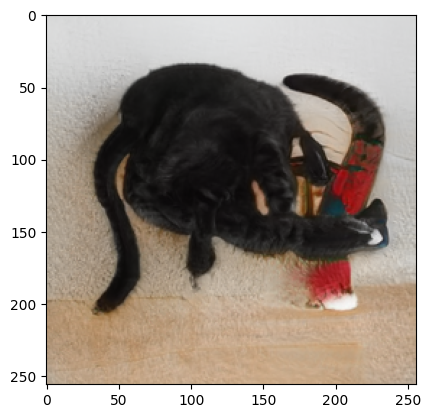

In [25]:
img, _  = gan([z], 0.7, c)
print(img.shape)
show_gan_im(img)

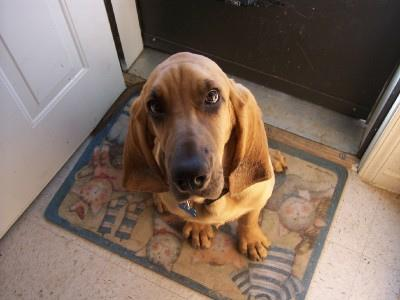

In [26]:
#real_im = Image.open("/home/amildravid/bigGAN-DINO_swap/val_im/ILSVRC2012_val_00028617-_1_.jpg")
#real_im = Image.open("/home/amildravid/bigGAN-DINO_swap/golden_retriever/real/ILSVRC2012_val_00001112.jpg")
#real_im = Image.open("/home/amildravid/bigActivation_Matching/val_im/ILSVRC2012_val_00006981.jpg")
real_im = Image.open("/kaggle/input/stanford-dogs-dataset/images/Images/n02088466-bloodhound/n02088466_10335.jpg")
#real_im = Image.open("/home/amildravid/bigGAN-DINO_swap/golden_retriever/sketch/sketch_7.jpg")
real_im

In [27]:
!mkdir -p imgs/dir0
!mkdir -p imgs/dir1

In [28]:
real_im = torchvision.transforms.ToTensor()(real_im).unsqueeze(0).to(device)
#real_im = torchvision.transforms.RandomResizedCrop(256)(real_im)
real_im = torch.nn.functional.interpolate(real_im, size = (256,256), mode = "bicubic")
dino_real_im = torch.nn.functional.interpolate(real_im, size = (256,256), mode = "bicubic")
dino_real_im = torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(dino_real_im)

In [29]:
!pwd

/kaggle/working/rosetta_neurons


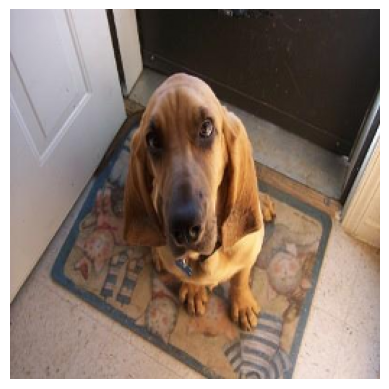

In [30]:
plt.imshow(torch.permute(real_im[0], (1,2,0)).cpu())
plt.axis('off')
plt.savefig( "imgs/dir0/image_1.jpg")
plt.show()

In [31]:
dino(dino_real_im)
dino_activs =  matching.store_activs(dino, dino_layers)
#normalize
eps = 0.00001
for i,_ in enumerate(dino_activs):
    dino_activs[i] = (dino_activs[i]-dino_stats[i][0])/(dino_stats[i][1]+eps)

In [32]:
dino_perfect_activs = []
for idx in dino_perfect_matches:
    dino_perfect_activs.append(dino_activs[idx[0]][:,idx[1],:,:].unsqueeze(0))

### Pixel Loss

In [33]:
optim = torch.optim.Adam([z], lr=0.01, betas=(0.5, 0.999))  

/kaggle/working/rosetta_neurons/stylegan2/op/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 2.0.0. Falling back to torch.nn.functional.conv2d().
  warnings.warn(


torch.Size([1, 3, 256, 256])
E: 1 loss: 0.12614265084266663


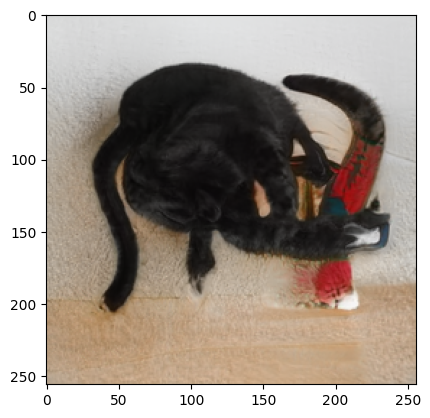

torch.Size([1, 3, 256, 256])
E: 21 loss: 0.03994212672114372


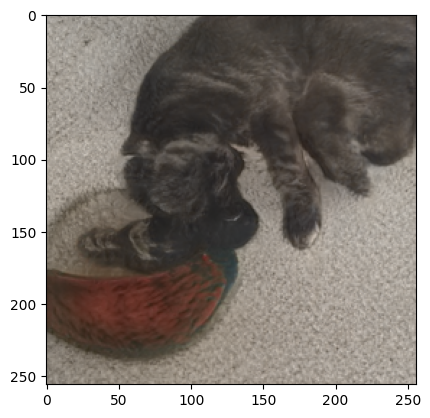

torch.Size([1, 3, 256, 256])
E: 41 loss: 0.028816446661949158


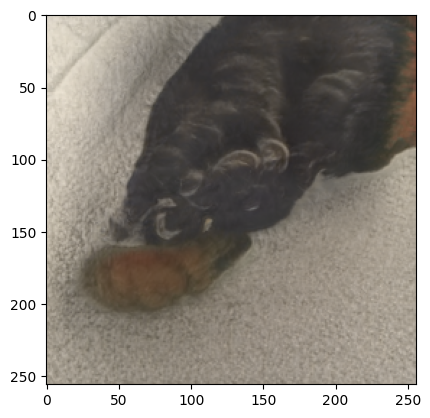

torch.Size([1, 3, 256, 256])
E: 61 loss: 0.02870228700339794


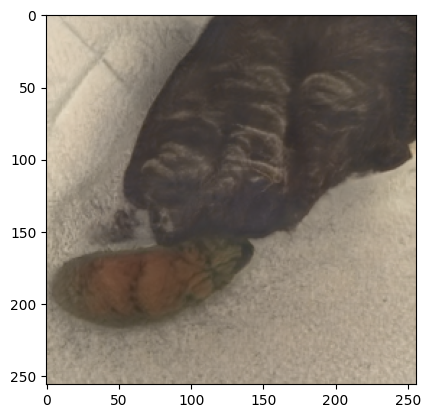

torch.Size([1, 3, 256, 256])
E: 81 loss: 0.028477950021624565


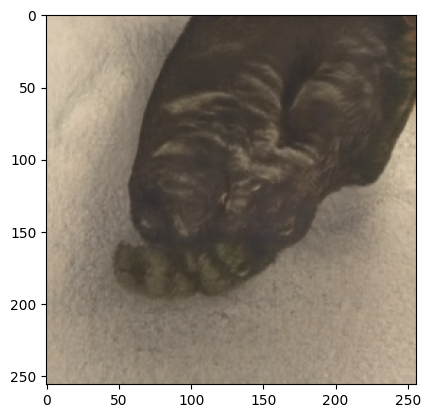

torch.Size([1, 3, 256, 256])
E: 101 loss: 0.026340579614043236


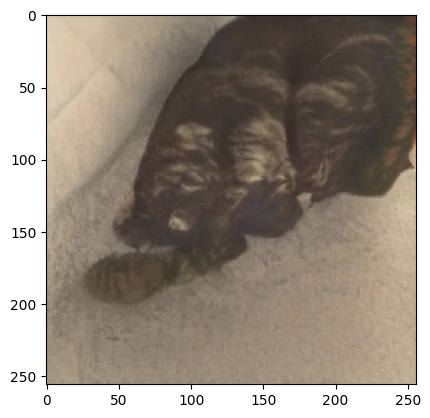

torch.Size([1, 3, 256, 256])
E: 121 loss: 0.02604593336582184


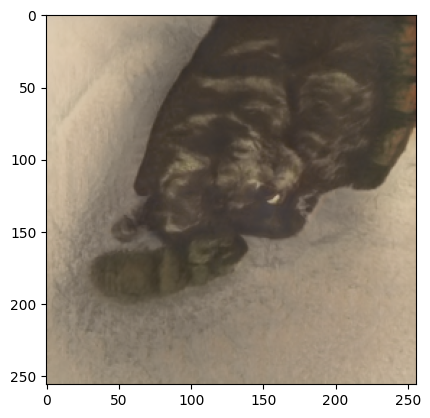

torch.Size([1, 3, 256, 256])
E: 141 loss: 0.027224261313676834


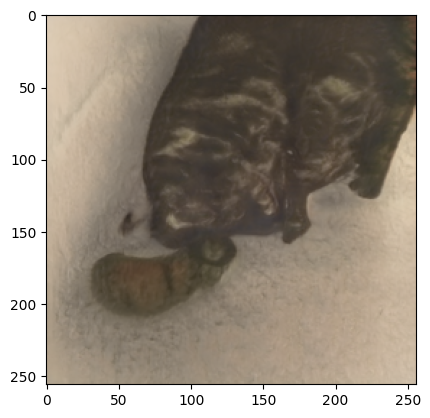

torch.Size([1, 3, 256, 256])
E: 161 loss: 0.027014899998903275


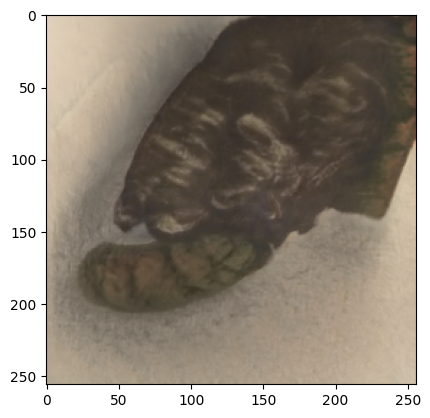

torch.Size([1, 3, 256, 256])
E: 181 loss: 0.026268770918250084


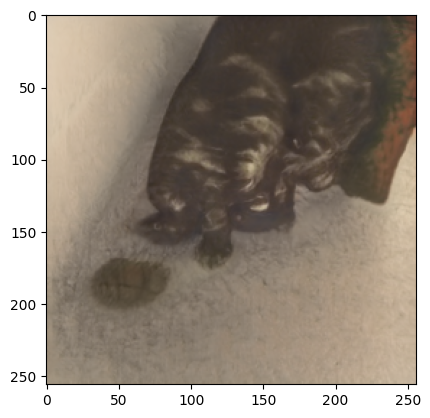

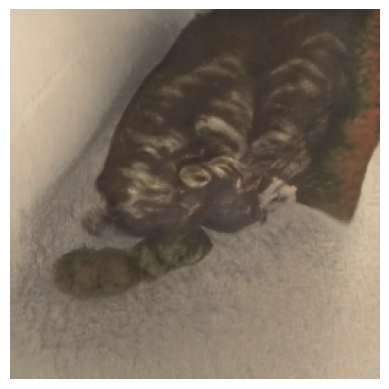

In [34]:
for epoch in range(0,200):
    
    optim.zero_grad()
    sample,_ = gan([z],0.7,c)
    im = (sample+1)/2
    if(epoch%20==0):
        print(im.shape)
    
    loss = torch.mean((im-real_im)**2)
    
    
    
    if(epoch%20==0):
        print("E:", epoch+1, "loss:", loss.item())
    loss.backward()
    optim.step()
    if(epoch%20==0):
        show_gan_im(sample)
    
    
    im = torch.permute(sample[0],(1,2,0)).detach().cpu().numpy()
    im = (im+1)/2
    
    
    if epoch<=9:
        file_name = "00"+str(epoch)+".jpg"
    elif epoch<=99:
        file_name = "0"+str(epoch)+".jpg"
    else: 
        file_name = str(epoch)+".jpg"
   # plt.imsave(save_path+file_name, im)  
plt.imshow(im)
plt.axis('off')
plt.savefig( f"pixel_loss_{file_name}")
plt.show()

# Activation Loss

In [35]:
optim = torch.optim.Adam([z], lr=0.01, betas=(0.5, 0.999))  

/kaggle/working/rosetta_neurons/stylegan2/op/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 2.0.0. Falling back to torch.nn.functional.conv2d().
  warnings.warn(


E: 1 loss: -15.148997642246625


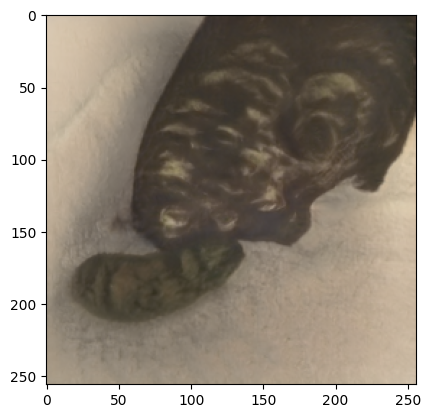

E: 21 loss: -36.41700355818171


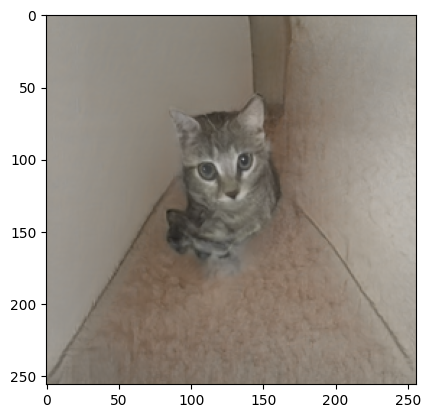

E: 41 loss: -37.372735287775036


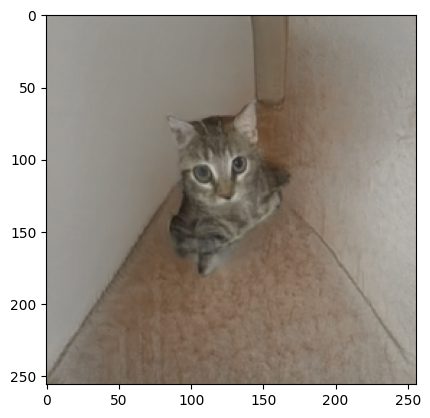

E: 61 loss: -37.616303193556526


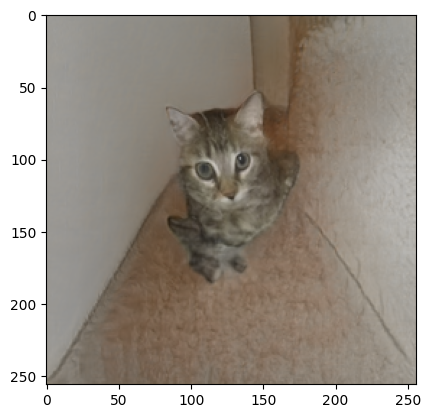

E: 81 loss: -37.84713921071403


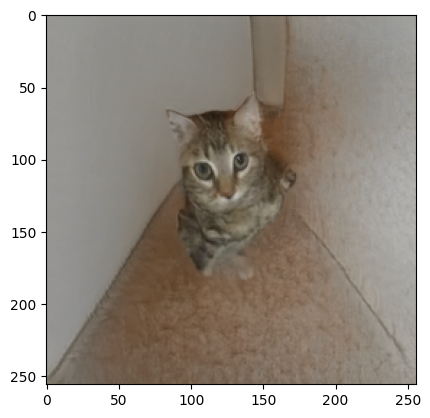

E: 101 loss: -37.5823707288012


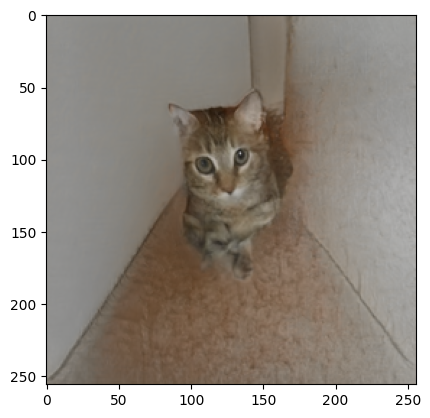

E: 121 loss: -38.37641722232077


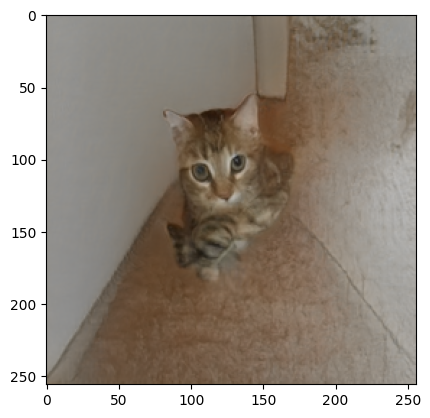

E: 141 loss: -38.07134467820673


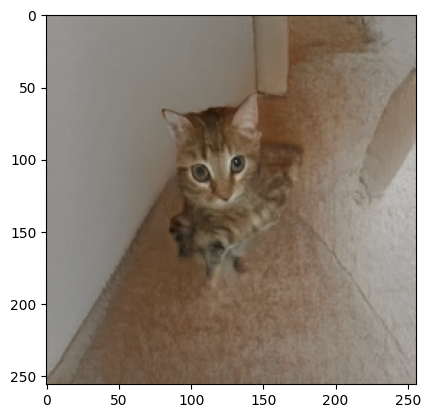

E: 161 loss: -38.404500262855045


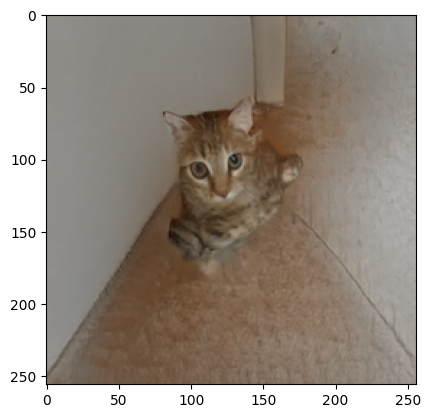

E: 181 loss: -38.57627202890386


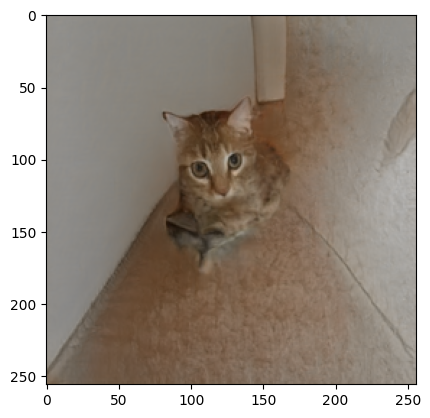

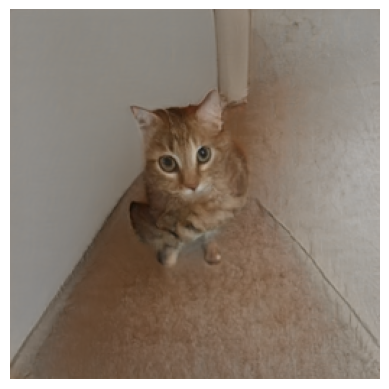

In [36]:
for epoch in range(0,200):
    
    optim.zero_grad()
    sample,_ = gan([z],0.7,c)
    
    
    
    gan_activs = matching.store_activs(gan, gan_layers)
    
    
    #normalize all activations
    eps = 0.00001
    for i,_ in enumerate(gan_activs):
        gan_activs[i] = (gan_activs[i]-gan_stats[i][0])/(gan_stats[i][1]+eps)
        
    
    gan_perfect_activs = []
    for idx in perfect_matches:
        gan_perfect_activs.append(gan_activs[idx[0]][:,idx[1],:,:])
    
    
    loss = 0
    losses = []
    for i, _ in enumerate(gan_perfect_activs): 
        map_size = max((gan_perfect_activs[i].shape[1], dino_perfect_activs[i].shape[1]))
        gan_activ_new = torch.nn.Upsample(size=(map_size,map_size), mode='bilinear')(gan_perfect_activs[i].unsqueeze(0))
        dino_activ_new = torch.nn.Upsample(size=(map_size,map_size), mode='bilinear')(dino_perfect_activs[i])   
        #loss += torch.einsum('aixy,ajxy->ij', gan_activ_new,dino_activ_new)/(map_size**2)
        prod = torch.einsum('aixy,ajxy->ij', gan_activ_new,dino_activ_new)
        div1 = torch.sum(gan_activ_new**2)
        div2 = torch.sum(dino_activ_new**2)
        corr = prod/torch.sqrt(div1*div2)
        loss += corr
        losses.append(corr)
        #loss += torch.mean((gan_activ_new-dino_activ_new)**2)
        
        
        
    loss *= -1 
    #regularization = 50*torch.mean((z-reg)**2)
    #loss +=  regularization
    if(epoch%20==0):
        print("E:", epoch+1, "loss:", loss.item())
    loss.backward()
    optim.step()
    if(epoch%20==0):
        show_gan_im(sample)
    im = (sample+1)/2
    
    im = torch.permute(sample[0],(1,2,0)).detach().cpu().numpy()
    im = (im+1)/2
    
    
    if epoch<=9:
        file_name = "00"+str(epoch)+".jpg"
    elif epoch<=99:
        file_name = "0"+str(epoch)+".jpg"
    else: 
        file_name = str(epoch)+".jpg"
    
    #plt.imsave(save_path+file_name, im)
plt.imshow(im)
plt.axis('off')
plt.savefig( f"activation_loss_{file_name}")
plt.show()

### Both Losses

In [37]:
optim = torch.optim.Adam([z], lr=0.01, betas=(0.5, 0.999))  

/kaggle/working/rosetta_neurons/stylegan2/op/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 2.0.0. Falling back to torch.nn.functional.conv2d().
  warnings.warn(


tensor(0.0497, device='cuda:0', grad_fn=<MeanBackward0>)
tensor([[-38.6502]], device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)
E: 1 loss: -33.67954133369271


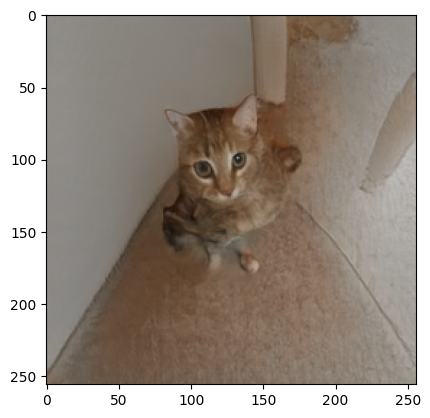

tensor(0.0373, device='cuda:0', grad_fn=<MeanBackward0>)
tensor([[-38.9943]], device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)
E: 21 loss: -35.268162397145026


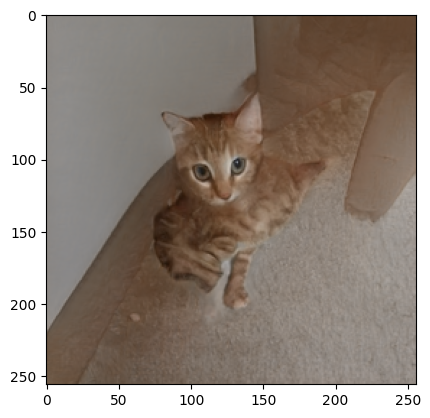

tensor(0.0371, device='cuda:0', grad_fn=<MeanBackward0>)
tensor([[-40.1850]], device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)
E: 41 loss: -36.47870820763165


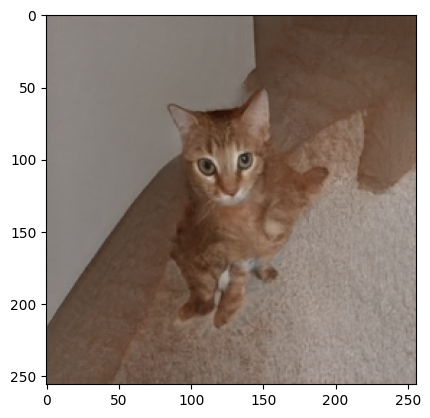

tensor(0.0368, device='cuda:0', grad_fn=<MeanBackward0>)
tensor([[-40.5189]], device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)
E: 61 loss: -36.83617879147105


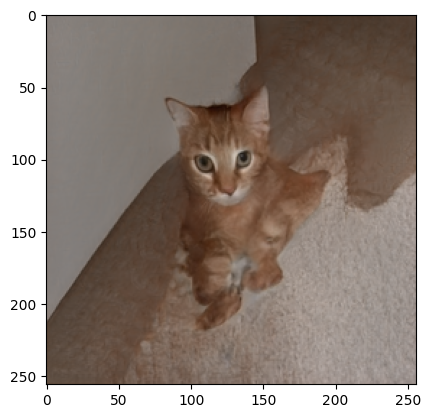

tensor(0.0360, device='cuda:0', grad_fn=<MeanBackward0>)
tensor([[-40.6582]], device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)
E: 81 loss: -37.06297874165847


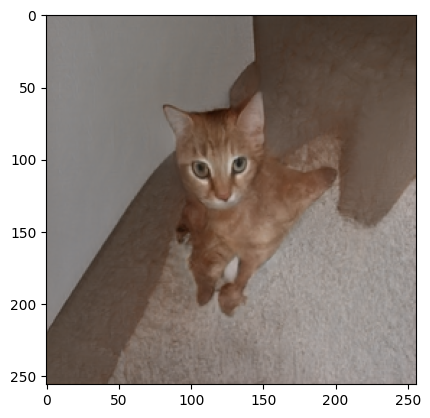

tensor(0.0423, device='cuda:0', grad_fn=<MeanBackward0>)
tensor([[-39.3349]], device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)
E: 101 loss: -35.103673278300285


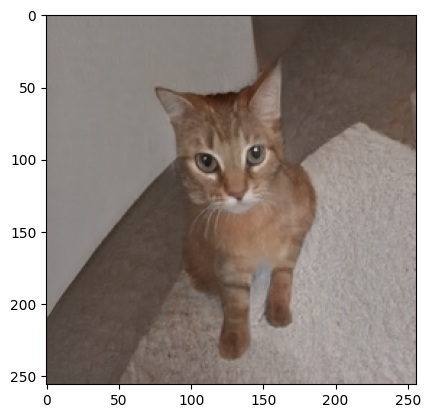

tensor(0.0364, device='cuda:0', grad_fn=<MeanBackward0>)
tensor([[-41.1669]], device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)
E: 121 loss: -37.531137696271614


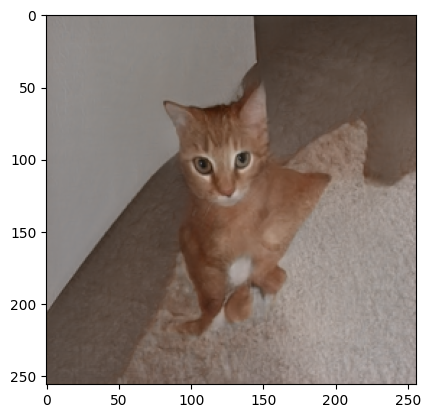

tensor(0.0359, device='cuda:0', grad_fn=<MeanBackward0>)
tensor([[-40.8557]], device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)
E: 141 loss: -37.26363043367252


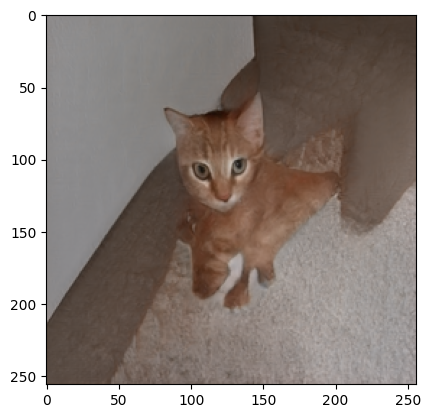

tensor(0.0371, device='cuda:0', grad_fn=<MeanBackward0>)
tensor([[-41.2153]], device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)
E: 161 loss: -37.503824087368784


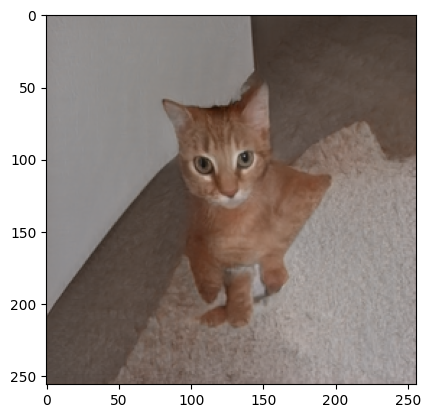

tensor(0.0359, device='cuda:0', grad_fn=<MeanBackward0>)
tensor([[-41.4423]], device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)
E: 181 loss: -37.85104363249697


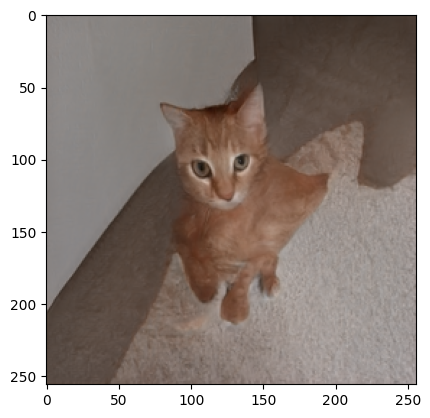

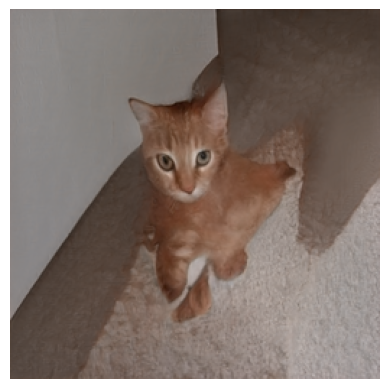

In [38]:
for epoch in range(0,200):
    
    optim.zero_grad()
    sample,_ = gan([z],0.7,c)
    
    im = (sample+1)/2
    pixel_loss = torch.mean((im-real_im)**2)
    
    
    if(epoch%20==0):
        print(pixel_loss)
    
    
    gan_activs = matching.store_activs(gan, gan_layers)
    
    
    #normalize all activations
    eps = 0.00001
    for i,_ in enumerate(gan_activs):
        gan_activs[i] = (gan_activs[i]-gan_stats[i][0])/(gan_stats[i][1]+eps)
        
    
    gan_perfect_activs = []
    for idx in perfect_matches:
        gan_perfect_activs.append(gan_activs[idx[0]][:,idx[1],:,:])
    
    
    loss = 0
    losses = []
    for i, _ in enumerate(gan_perfect_activs): 
        map_size = max((gan_perfect_activs[i].shape[1], dino_perfect_activs[i].shape[1]))
        gan_activ_new = torch.nn.Upsample(size=(map_size,map_size), mode='bilinear')(gan_perfect_activs[i].unsqueeze(0))
        dino_activ_new = torch.nn.Upsample(size=(map_size,map_size), mode='bilinear')(dino_perfect_activs[i])   
        #loss += torch.einsum('aixy,ajxy->ij', gan_activ_new,dino_activ_new)/(map_size**2)
        prod = torch.einsum('aixy,ajxy->ij', gan_activ_new,dino_activ_new)
        div1 = torch.sum(gan_activ_new**2)
        div2 = torch.sum(dino_activ_new**2)
        corr = prod/torch.sqrt(div1*div2)
        loss += corr
        losses.append(corr)
        #loss += torch.mean((gan_activ_new-dino_activ_new)**2)
        
        
        
    loss *= -1 
    if(epoch%20==0):
        print(loss)
    loss += 100*pixel_loss
    
    
    #regularization = 100*torch.mean((z-reg)**2)
        #loss +=  regularization
    if(epoch%20==0):
        print("E:", epoch+1, "loss:", loss.item())
    loss.backward()
    optim.step()
    if(epoch%20==0):
        show_gan_im(sample)
    im = (sample+1)/2
    
    im = torch.permute(sample[0],(1,2,0)).detach().cpu().numpy()
    im = (im+1)/2
    
    
    if epoch<=9:
        file_name = "00"+str(epoch)+".jpg"
    elif epoch<=99:
        file_name = "0"+str(epoch)+".jpg"
    else: 
        file_name = str(epoch)+".jpg"
    
    #plt.imsave(save_path+file_name, im)
plt.imshow(im)
plt.axis('off')
plt.savefig( f"imgs/dir1/image_1.jpg")
plt.show()

In [39]:
!pip install lpips

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.2 MB/s eta 0:00:00


In [40]:
!ls /opt/conda/lib/python3.10/site-packages/lpips

__init__.py  __pycache__  lpips.py  pretrained_networks.py  trainer.py	weights


In [41]:
code = '''
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import torch
# from torch.autograd import Variable

from lpips.trainer import *
from lpips.lpips import *

def normalize_tensor(in_feat,eps=1e-10):
    norm_factor = torch.sqrt(torch.sum(in_feat**2,dim=1,keepdim=True))
    return in_feat/(norm_factor+eps)

def l2(p0, p1, range=255.):
    return .5*np.mean((p0 / range - p1 / range)**2)

def psnr(p0, p1, peak=255.):
    return 10*np.log10(peak**2/np.mean((1.*p0-1.*p1)**2))

def dssim(p0, p1, range=255.):
    from skimage.measure import compare_ssim
    return (1 - compare_ssim(p0, p1, data_range=range, multichannel=True)) / 2.

def tensor2np(tensor_obj):
    # change dimension of a tensor object into a numpy array
    return tensor_obj[0].cpu().float().numpy().transpose((1,2,0))

def np2tensor(np_obj):
     # change dimenion of np array into tensor array
    return torch.Tensor(np_obj[:, :, :, np.newaxis].transpose((3, 2, 0, 1)))

def tensor2tensorlab(image_tensor,to_norm=True,mc_only=False):
    # image tensor to lab tensor
    from skimage import color

    img = tensor2im(image_tensor)
    img_lab = color.rgb2lab(img)
    if(mc_only):
        img_lab[:,:,0] = img_lab[:,:,0]-50
    if(to_norm and not mc_only):
        img_lab[:,:,0] = img_lab[:,:,0]-50
        img_lab = img_lab/100.

    return np2tensor(img_lab)

def tensorlab2tensor(lab_tensor,return_inbnd=False):
    from skimage import color
    import warnings
    warnings.filterwarnings("ignore")

    lab = tensor2np(lab_tensor)*100.
    lab[:,:,0] = lab[:,:,0]+50

    rgb_back = 255.*np.clip(color.lab2rgb(lab.astype('float')),0,1)
    if(return_inbnd):
        # convert back to lab, see if we match
        lab_back = color.rgb2lab(rgb_back.astype('uint8'))
        mask = 1.*np.isclose(lab_back,lab,atol=2.)
        mask = np2tensor(np.prod(mask,axis=2)[:,:,np.newaxis])
        return (im2tensor(rgb_back),mask)
    else:
        return im2tensor(rgb_back)

def load_image(path):
    if(path[-3:] == 'dng'):
        import rawpy
        with rawpy.imread(path) as raw:
            img = raw.postprocess()
    elif(path[-3:]=='bmp' or path[-3:]=='jpg' or path[-3:]=='png' or path[-4:]=='jpeg'):
        import cv2
        return cv2.imread(path)[:,:,::-1]
    else:
        import matplotlib.pyplot as plt        
        img = (255*plt.imread(path)[:,:,:3]).astype('uint8')

    return img

def tensor2im(image_tensor, imtype=np.uint8, cent=1., factor=255./2.):
    image_numpy = image_tensor[0].cpu().float().numpy()
    image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + cent) * factor
    return image_numpy.astype(imtype)

def im2tensor(image, imtype=np.uint8, cent=1., factor=255./2.):
    return torch.Tensor((image / factor - cent)
                        [:, :, :, np.newaxis].transpose((3, 2, 0, 1)))

def tensor2vec(vector_tensor):
    return vector_tensor.data.cpu().numpy()[:, :, 0, 0]


def voc_ap(rec, prec, use_07_metric=False):
    """ ap = voc_ap(rec, prec, [use_07_metric])
    Compute VOC AP given precision and recall.
    If use_07_metric is true, uses the
    VOC 07 11 point method (default:False).
    """
    if use_07_metric:
        # 11 point metric
        ap = 0.
        for t in np.arange(0., 1.1, 0.1):
            if np.sum(rec >= t) == 0:
                p = 0
            else:
                p = np.max(prec[rec >= t])
            ap = ap + p / 11.
    else:
        # correct AP calculation
        # first append sentinel values at the end
        mrec = np.concatenate(([0.], rec, [1.]))
        mpre = np.concatenate(([0.], prec, [0.]))

        # compute the precision envelope
        for i in range(mpre.size - 1, 0, -1):
            mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

        # to calculate area under PR curve, look for points
        # where X axis (recall) changes value
        i = np.where(mrec[1:] != mrec[:-1])[0]

        # and sum (\Delta recall) * prec
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap'''

In [42]:
with open("/opt/conda/lib/python3.10/site-packages/lpips/__init__.py","w") as f:
    f.write(code)

In [43]:
!python calc_metrics.py  --dir0 /kaggle/working/rosetta_neurons/imgs/dir0 --dir1 /kaggle/working/rosetta_neurons/imgs/dir1 -o imgs_dist.txt --use_gpu --version 0.1

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/kaggle/working/rosetta_neurons/calc_metrics.py:92: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET